## CT5133 / CT5145 Deep Learning (/Online) 2022-2023

## Assignment 2

## James McDermott

* Student ID(s): 22229358
* Student name(s): KOSTADIN GEORGIEV

**Due date**: midnight Sunday 19 March (end Week 10).

**Weighting**: 20% of the module.

In this assignment the goal is to take advantage of pre-trained NN models to create an embedding with a dataset of movie posters, and demonstrate how to use that embedding.

The dataset is provided, along with some skeleton code for loading it.

The individual steps to be carried out are specified below, with `### YOUR CODE HERE` markers, together with the number of marks available for each part.

* **Topics**: in Part 5 below, students are asked to add some improvement to their models. In general, these improvements will differ between students (or student groups). **The proposed improvement must be notified to the lecturer at least 1 week before submission, and approved by the lecturer**. If working in a group, the two members of the group should not work on different topics in Part 5: they must work on the same topic and submit identical submissions.

* Students are not required to work incrementally on the parts. It is ok to do all the work in one day, so long as you abide by the rules on notifying groups and notifying topics.

* **Groups**: students may work solo or in a group of two. A student may not work together in a group with any student they have previously worked on a group project with, in this module or any other in the MSc programme. **Groups must be notified to the lecturer in writing before beginning work and at least 1 week before submission.** If working in a group, both students must submit and both submissions must be identical. If working in a group, both students may be asked to explain any aspect of the code in interview (see below), therefore working independently on separate components is not recommended. Any emails concerning the project should be cc-ed to the other group member.

* **Libraries**: code can be written in Keras/Tensorflow, or in PyTorch. 

* **Plagiarism**: students may discuss the assignment together, but you may not look at another student or group's work or allow other students to view yours (other than within a group). You may use snippets of code (eg 1-2 lines) from the internet, **if you provide a citation with URL**. You may also use a longer snippet of code if it is a utility function, again only with citation. You may not use code from the internet to carry out the core of the assignment. You may not use a large language model to generate code.

* **Submission**: after completing your work in this Jupyter notebook, submit the notebook both in `.ipynb` and `.pdf` formats. The content should be identical.

* **Interviews**: a number of students may be selected for interview, post-submission. The selection will depend on submissions, and random chance may be used also. Interviews will be held in-person (CT5133) or online (CT5145). Interviews will last approximately 10 minutes. The purpose of interviews will be to assess students' understanding of their own submission.


### Dataset Credits

The original csv file is from: 

https://www.kaggle.com/datasets/neha1703/movie-genre-from-its-poster

I have added the *year* column for convenience.

I believe most of the information is originally from the famous MovieLens dataset:

* https://grouplens.org/datasets/movielens/
* https://movielens.org/

However, I'm not clear whether the poster download URLs (Amazon AWS URLs) which are in the csv obtained from the Kaggle URL above are from a MovieLens source, or elsewhere.

To create the dataset we are using, I have randomly sampled a small proportion of the URLs in the csv, and downloaded the images. I have removed those which fail to download. Code below also filters out those which are in black and white, ie 1 channel only.

### Imports

You can add more imports if needed.

In [1]:
import numpy as np
import pandas as pd
import os
from PIL import Image
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist, pdist, squareform # useful for distances in the embedding

In [2]:
import tensorflow as tf
from tensorflow import keras
from keras import layers, models

In [3]:
from keras.applications import VGG16
from keras.applications.vgg16 import preprocess_input
from sklearn.model_selection import train_test_split

### Utility functions

These functions are provided to save you time. You might not need to understand any of the details here.

In [4]:
# walk the directory containing posters and read them in. all are the same shape: (268, 182).
# all have 3 channels, with a few exceptions (see below).
# each is named <imdbId>.jpg, which will later allow us to get the metadata from the csv.
IDs = []
images = []
for dirname, _, filenames in os.walk('DL_Sample'):
    for filename in filenames:
        if filename.endswith(".jpg"):
            ID = int(filename[:-4])
            pathname = os.path.join(dirname, filename)
            im = Image.open(pathname)
            imnp = np.array(im, dtype=float)
            if len(imnp.shape) != 3: # we'll ignore a few black-and-white (1 channel) images
                print("This is 1 channel, so we omit it", imnp.shape, filename)
                continue # do not add to our list
            IDs.append(ID)
            images.append(imnp)

This is 1 channel, so we omit it (268, 182) 290031.jpg
This is 1 channel, so we omit it (268, 182) 294266.jpg
This is 1 channel, so we omit it (268, 182) 30337.jpg
This is 1 channel, so we omit it (268, 182) 3626440.jpg
This is 1 channel, so we omit it (268, 182) 50192.jpg
This is 1 channel, so we omit it (268, 182) 54880.jpg
This is 1 channel, so we omit it (268, 182) 57006.jpg


In [5]:
img_array = np.array(images)

In [6]:
img_array.shape

(1254, 268, 182, 3)

In [7]:
# read the csv
df = pd.read_csv("Movie_Genre_Year_Poster.csv", encoding="ISO-8859-1", index_col="Unnamed: 0")
df.head()

,imdbId,Imdb Link,Title,IMDB Score,Genre,Poster,Year
0,114709,http://www.imdb.com/title/tt114709,Toy Story (1995),8.3,Animation|Adventure|Comedy,https://images-na.ssl-images-amazon.com/images...,1995.0
1,113497,http://www.imdb.com/title/tt113497,Jumanji (1995),6.9,Action|Adventure|Family,https://images-na.ssl-images-amazon.com/images...,1995.0
2,113228,http://www.imdb.com/title/tt113228,Grumpier Old Men (1995),6.6,Comedy|Romance,https://images-na.ssl-images-amazon.com/images...,1995.0
3,114885,http://www.imdb.com/title/tt114885,Waiting to Exhale (1995),5.7,Comedy|Drama|Romance,https://images-na.ssl-images-amazon.com/images...,1995.0
4,113041,http://www.imdb.com/title/tt113041,Father of the Bride Part II (1995),5.9,Comedy|Family|Romance,https://images-na.ssl-images-amazon.com/images...,1995.0


In [8]:
df2 = df.drop_duplicates(subset=["imdbId"]) # some imdbId values are duplicates - just drop

In [9]:
df3 = df2.set_index("imdbId") # the imdbId is a more useful index, eg as in the next cell...

In [10]:
df4 = df3.loc[IDs] # ... we can now use .loc to take a subset

In [11]:
df4.shape # 1254 rows matches the image data shape above

(1254, 6)

In [12]:
years = df4["Year"].values
titles = df4["Title"].values

assert img_array.shape[0] == years.shape[0] == titles.shape[0]

In [16]:
def imread(filename):
    """Convenience function: we can supply an ID or a filename.
    We read and return the image in Image format.
    """
    
    if type(filename) == int:
        # assume its an ID, so create filename
        filename = f"DL_Sample/{filename}.jpg"
        
    # now we can assume it's a filename, so open and read
    im = Image.open(filename)
    
    return im

def imshow(im):
    plt.imshow(im)
    plt.axis('off')

### Part 1. Create embedding [3 marks]

Use a pretrained model, eg as provided by Keras, to create a flat (ie 1D) embedding vector of some size `embedding_size` for each movie poster, and put all of these together into a single tensor of shape `(n_movies, embedding_size)`.

In [13]:
n_movies = img_array.shape[0]
embedding_size = 20480
X = tf.zeros((n_movies, embedding_size))

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(268, 182, 3))
flatten_layer = layers.Flatten()(base_model.output)
embeddings_model = models.Model(inputs=base_model.inputs, outputs=flatten_layer)

img_input = preprocess_input(img_array)
X = embeddings_model.predict(img_input)

assert len(X.shape) == 2 # X should be (n_movies, embedding_size)
assert X.shape[0] == n_movies

40/40 [==============================] - 140s 3s/step


### Part 2. Define a nearest-neighbour function [3 marks]

Write a function `def nearest(img, k)` which accepts an image `img`, and returns the `k` movies in the dataset whose posters are most similar to `img` (as measured in the embedding), ranked by similarity. 

In [17]:
def k_nearest(img, k):
    ''' Expected image should be of shape (268, 182, 3) '''
    x = np.expand_dims(img, axis=0)
    x = preprocess_input(x)

    x = embeddings_model.predict(x)
    distances = cdist(x, X, metric='cosine')
    
    # Start idx from 2nd element because the image is
    # going to be closest to itself each time.
    closest_emb_ids = np.argsort(distances)[0][1:k + 1]
    closest_img_ids = [IDs[i] for i in closest_emb_ids]
    
    return closest_img_ids

### Part 3: Demonstrate your nearest-neighbour function [4 marks]

Choose any movie poster. Call this the query poster. Show it, and use your nearest-neighbour function to show the 3 nearest neighbours (excluding the query itself). This means **call** the function you defined above.

Write a comment: in what ways are they similar or dissimilar? Do you agree with the choice and the ranking? Why do you think they are close in the embedding? Do you notice, for example, that the nearest neighbours are from a similar era? 


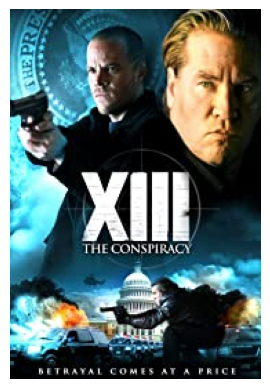

In [18]:
np.random.seed(22229358 + 2023)
Q_idx = int(np.random.choice(IDs))
imshow(imread(Q_idx))

In [19]:
x = np.array(imread(Q_idx))
neighbours = k_nearest(x, 3)

1/1 [==============================] - 0s 185ms/step


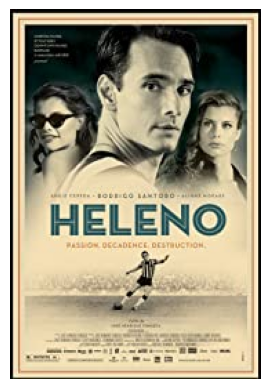

In [20]:
imshow(imread(neighbours[0]))

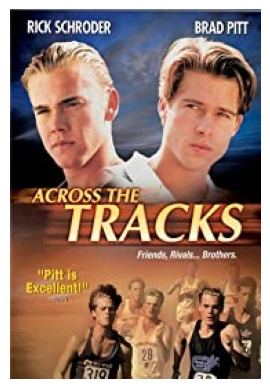

In [21]:
imshow(imread(neighbours[1]))

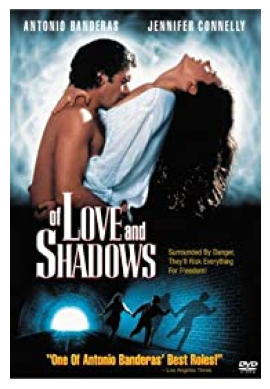

In [22]:
imshow(imread(neighbours[2]))

The input poster is from "XIII: The Conspiracy" (2008).

The 3 closest neighbours are:
* Heleno (2011)
* Across the Tracks (1991)
* Of Love and Shadows (1994)

Generally all those 4 movie posters give a 20-th century vibe. Another common thing is that their release dates are all within a 20 year period which is relatively close. I suppose another reason the embeddings are close in the vector space is because from a compositional point of view all 4 posters feature close up portrait images of 2 or 3 people in the upper-central part of the poster and also a big title headline in the center of each image. VGG16 must be able to detect that those objects are similar in terms of type and in terms of relative position.

### Part 4: Year regression [5 marks]

Let's investigate the last question ("similar era") above by running **regression** on the year, ie attempt to predict the year, given the poster. Use a train-test split. Build a suitable Keras neural network model for this, **as a regression head on top of the embedding from Part 1**. Include comments to explain the purpose of each part of the model. It should be possible to make a prediction, given a new poster (not part of the original dataset). Write a short comment on model performance: is it possible to predict the year? Based on this result, are there trends over time?

In [67]:
def filter_nan_years(img, label):
    i, l = zip(*[(x, y) for x, y in zip(img, label) if np.isnan(y) == False])
    return np.array(i), np.array(l)

labels = df4['Year'].values
filtered_images, filtered_labels = filter_nan_years(img_array, labels)

# This layer will shift and scale inputs into a distribution centered around
# 0 with standard deviation 1
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(filtered_images))

(X_train, X_test,
 y_train, y_test) = train_test_split(filtered_images, filtered_labels,
                                     train_size = 0.8, random_state = 22229358)

# Freeze the weights of the base model
for layer in base_model.layers:
    layer.trainable = False

# Simple architecture consisting of the base of the VGG16 pre-trained model,
# which produces embeddings of the input image, followed by a fully-connected
# head which performs regression. The number of hidden layers and number of
# nodes were detirminded by trial and error with a few different configurations
# while keeping track of the behaviour of the training and the validation loss.
# The output layer has one node with linear activation which produces a prediction
# which is a single float value representing the year of the input movie.
regression_model = models.Sequential()
regression_model.add(base_model)
regression_model.add(layers.Flatten())
regression_model.add(layers.Dense(320, activation='relu'))
regression_model.add(layers.Dense(160, activation='relu'))
regression_model.add(layers.Dense(1))

regression_model.compile(loss='mean_absolute_error',
                         optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))

history = regression_model.fit(
    X_train,
    y_train,
    batch_size = 1, #32
    epochs = 20,
    validation_split = 0.2)

result = regression_model.evaluate(X_test, y_test)
result

Epoch 1/20
792/792 [==============================] - 167s 206ms/step - loss: 436.5148 - val_loss: 426.2527
Epoch 2/20
792/792 [==============================] - 163s 205ms/step - loss: 331.2046 - val_loss: 364.7243
Epoch 3/20
792/792 [==============================] - 162s 204ms/step - loss: 253.2559 - val_loss: 271.6909
Epoch 4/20
792/792 [==============================] - 162s 205ms/step - loss: 220.5404 - val_loss: 254.2661
Epoch 5/20
792/792 [==============================] - 163s 206ms/step - loss: 189.1065 - val_loss: 257.3534
Epoch 6/20
792/792 [==============================] - 162s 204ms/step - loss: 163.8353 - val_loss: 267.2891
Epoch 7/20
792/792 [==============================] - 164s 207ms/step - loss: 159.7277 - val_loss: 311.0297
Epoch 8/20
792/792 [==============================] - 162s 204ms/step - loss: 140.8917 - val_loss: 265.5345
Epoch 9/20
792/792 [==============================] - 164s 207ms/step - loss: 135.6474 - val_loss: 261.9962
Epoch 10/20
792/792 [=======

278.021484375

The model has achieved 278 mean absolute error.

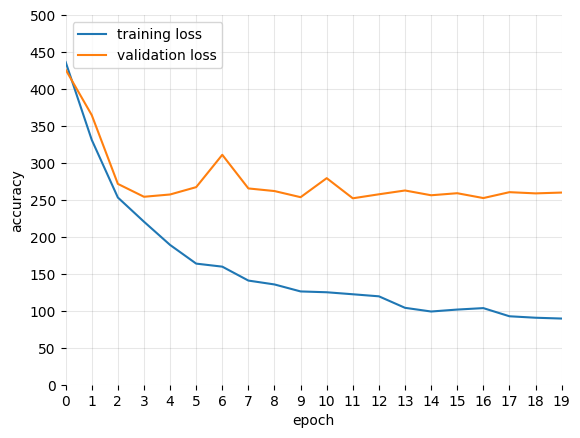

In [79]:
plt.figure(0)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training loss', 'validation loss'], loc='upper left')
plt.xlim(0, 19)
plt.xticks(np.arange(0, 20, 1))
plt.ylim(0, 500)
plt.yticks(np.arange(0, 501, 50))
plt.grid(True)
plt.rcParams['grid.color'] = (0.1, 0.1, 0.1, 0.1)
for pos in ['right', 'top', 'bottom', 'left']:
    plt.gca().spines[pos].set_visible(False)
plt.show()

Judging by the plot of the loss curve we can see how the model starts to overfit after epoch #2 (counting from 0). That is because the validation loss starts to diverge from the training loss. From epoch #3 we can see how the training loss continous to improve (decrese) while the validation loss hits a "support line" around 250 and from then on it only bounces from that line but doesn't really imporove beyond that level. That is a sure sign of overfitting.

### Part 5: Improvements [5 marks]

Propose a possible improvement. Some ideas are suggested below. The chosen improvement must be notified to the lecturer at least 1 week before submission and **must be approved by the lecturer to avoid duplication with other students**. Compare the performance between your original and your new model (the proposed improvement might not actually improve on model performance -- that is ok). Some marks will be awarded for more interesting / challenging / novel improvements.

Ideas:

* Try a different pretrained model for creating the embedding
* Alternative ways of reducing the pretrained model's output to a flat vector for the embedding
* Gather more data (see the csv file for URLs)
* Add different architectural details to the regression head
* Fine-tuning
* Training an end-to-end convnet of your own design (no pretraining)
* Improve the embedding by training a multi-headed model, eg predicting both genre and year
* Create a good visualisation of the embedding.


In [23]:
df_years = df4[df4['Year'] == df4['Year']][['Year']].sort_values(by='Year')
df_years

,Year
imdbId,
343112,1888.0
241715,1891.0
1740545,1898.0
2795,1913.0
212633,1916.0
...,...
5775370,2016.0
2937696,2016.0
2531318,2016.0


I made an observation that the years of all movies from the dataset are in the range between 1888-2016 (with some gaps). I wanted to check the distribution so I plotted the following histogram:

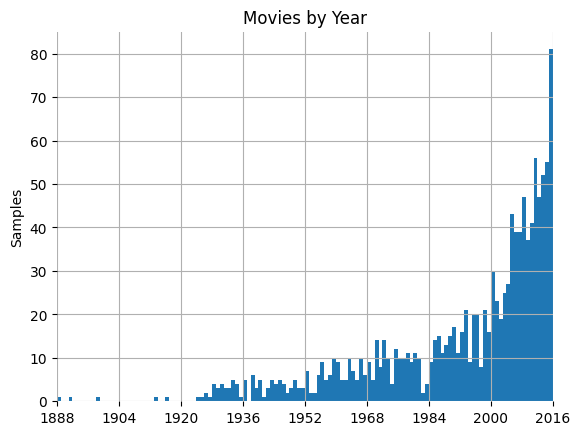

In [24]:
fig2 = plt.figure(1)
plt.hist(df_years, bins=128)
plt.gca().set(title='Movies by Year', ylabel='Samples')
plt.xlim(1888, 2016)
plt.xticks(np.arange(1888, 2017, 16))
plt.grid(True)
plt.rcParams['grid.color'] = (0.1, 0.1, 0.1, 0.1)
for pos in ['right', 'top', 'bottom', 'left']:
    plt.gca().spines[pos].set_visible(False)

Based on that, we can clearly see that the majority of years are very underrepresented in the dataset. In fact, only the most recent years have a reasonable number of samples. This makes for an extremely unbalanced dataset, meaning that any regression model might struggle in predicticting years that are underrepresented.

That is why I have decided to balance the dataset a little by scraping more data from IMDB. Based on looking at the histogram I have assumed that all samples preceeding the year 2000 are underrepresented so that is why I have decided to rebalance that part of the dataset. Then I have set a threshold `t` which I have set to 30. I then calculate the difference between that and the number of samples for each year which gives me the number of new samples that I need to add.

That way we can both increase the total number of training case and also guarantee that each year is represented by at least `t` samples in the dataset. Of course, the higher `t` is the better performance we can achieve, but for the purpose of this project I have decided to keep `t` at 30 because scraping data takes a lot of computational time.

In [25]:
df_years_counts = df_years.value_counts()
year_counts = {}
new_samples = {}
t = 30

for year in range(1888, 2017):
    if year in df_years_counts.index:
        year_counts[year] = df_years_counts[year]
    else:
        year_counts[year] = 0

for year, counts in year_counts.items():
    if t - counts > 0:
        new_samples[year] = t - counts
    else:
        new_samples[year] = 0

new_samples = pd.DataFrame(data={'year': new_samples.keys(),
                                 'count': new_samples.values()})

print("Number of new samples:",
      new_samples['count'].sum())
new_samples

Number of new samples: 2810


,year,count
0,1888,29
1,1889,30
2,1890,30
3,1891,29
4,1892,30
...,...,...
124,2012,0
125,2013,0
126,2014,0
127,2015,0


After calculating the number of new samples to be added per year the next step is to scrape the corresponding number of movies per year. For consistency purposes with the initial dataset, I have extracted some additional data about the movies which I don't need for this particular enhancement - those are the 'Imdb Link', 'Title', 'IMDB Score' and 'Genre' columns. One thing that we have to be careful about is that we have to make sure that we don't fetch movies that already exist in the initial dataset.

In [798]:
import requests
from bs4 import BeautifulSoup
import imdb

ia = imdb.IMDb()
top_movies = []

for year in range(1888, 2001):
    # This URL does an advanced search in IMDB for the top movies released in an year
    url = f'https://www.imdb.com/search/title/?release_date={year}-01-01,{year}-12-31'
    new_samples_count = int(new_samples[new_samples['year'] == year]['count'])
    retrieved_movies = 0

    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser')

    movies = soup.select(".lister-item-header a")
    genre = soup.select(".genre")

    for i in range(len(movies)):
        # We only want to add just as many movies for each year so we satisfy the threshold
        if retrieved_movies >= new_samples_count:
            break

        title = movies[i].text.strip()
        href = 'http://www.imdb.com' + movies[i]['href']
        imdb_id = href[href.find("/tt") + 3:href.rfind("/")]
        genr = '|'.join(genre[i].text.strip().replace("\n", "").split(", "))

        # Only add the movie it is not present in the initial dataset
        if int(imdb_id) not in IDs:
            top_movies.append({
                'imdbId': int(imdb_id),
                'Imdb Link': href,
                'Title': title,
                'IMDB Score': '',
                'Genre': genr,
                'Poster': '',
                'Year': float(year)
            })
            retrieved_movies += 1

In [845]:
df5 = pd.DataFrame(top_movies)
df5 = df5.set_index("imdbId")
df5

,Imdb Link,Title,IMDB Score,Genre,Poster,Year
imdbId,,,,,,
392728,http://www.imdb.com/title/tt0392728/,Roundhay Garden Scene,,Documentary|Short,,1888.0
1758563,http://www.imdb.com/title/tt1758563/,Accordion Player,,Documentary|Short,,1888.0
3274100,http://www.imdb.com/title/tt3274100/,Pferd und Reiter Springen über ein Hindernis,,Short,,1888.0
2116853,http://www.imdb.com/title/tt2116853/,Brighton Street Scene,,Documentary|Short,,1888.0
2116898,http://www.imdb.com/title/tt2116898/,Hyde Park Corner,,Short,,1889.0
...,...,...,...,...,...,...
120689,http://www.imdb.com/title/tt0120689/,The Green Mile,,Crime|Drama|Fantasy,,1999.0
133093,http://www.imdb.com/title/tt0133093/,The Matrix,,Action|Sci-Fi,,1999.0
149460,http://www.imdb.com/title/tt0149460/,Futurama,,Animation|Adventure|Comedy,,1999.0


We can see that a total of 2638 new movies have been fetched. The next step is to fetch the URLs of the movies' posters:

In [846]:
import movieposters as mp

df6 = df5

for imdbId, movie in df6.iterrows():
    try:
        url = mp.get_poster(str(imdbId))
        df6.at[imdbId, 'Poster'] = url
    except:
        print('Poster for imdgId', str(imdbId), 'not found')

Poster for imdgId 2116898 not found
Poster for imdgId 466876 not found
Poster for imdgId 2116968 not found
Poster for imdgId 3508566 not found
Poster for imdgId 5447082 not found
Poster for imdgId 241524 not found
Poster for imdgId 8742754 not found
Poster for imdgId 229231 not found
Poster for imdgId 192982 not found
Poster for imdgId 405123 not found
Poster for imdgId 1184937 not found
Poster for imdgId 7894132 not found
Poster for imdgId 350952 not found
Poster for imdgId 179 not found
Poster for imdgId 224240 not found
Poster for imdgId 176 not found
Poster for imdgId 229725 not found
Poster for imdgId 222452 not found
Poster for imdgId 291476 not found
Poster for imdgId 272 not found
Poster for imdgId 249743 not found
Poster for imdgId 6660444 not found
Poster for imdgId 312017 not found
Poster for imdgId 2087960 not found
Poster for imdgId 228629 not found
Poster for imdgId 368 not found
Poster for imdgId 417 not found
Poster for imdgId 399 not found
Poster for imdgId 227866 not 

In [26]:
df6.to_csv('Movie_Genre_Year_Poster_New.csv')

Remove the movies for which fetching the poster was unsuccessful:

In [27]:
df7 = df6[df6['Poster'] != '']
df7.to_csv('Movie_Genre_Year_Poster_New_Filtered.csv')
df7

,Imdb Link,Title,IMDB Score,Genre,Poster,Year
imdbId,,,,,,
392728,http://www.imdb.com/title/tt0392728/,Roundhay Garden Scene,NaN,Documentary|Short,https://m.media-amazon.com/images/M/MV5BMGY5OW...,1888.0
1758563,http://www.imdb.com/title/tt1758563/,Accordion Player,NaN,Documentary|Short,https://m.media-amazon.com/images/M/MV5BMDYxOD...,1888.0
3274100,http://www.imdb.com/title/tt3274100/,Pferd und Reiter Springen Ã¼ber ein Hindernis,NaN,Short,https://m.media-amazon.com/images/M/MV5BMjE1NT...,1888.0
2116853,http://www.imdb.com/title/tt2116853/,Brighton Street Scene,NaN,Documentary|Short,https://m.media-amazon.com/images/M/MV5BNDlhNz...,1888.0
2116898,http://www.imdb.com/title/tt2116898/,Hyde Park Corner,NaN,Short,NaN,1889.0
...,...,...,...,...,...,...
120689,http://www.imdb.com/title/tt0120689/,The Green Mile,NaN,Crime|Drama|Fantasy,https://m.media-amazon.com/images/M/MV5BMjZlMT...,1999.0
133093,http://www.imdb.com/title/tt0133093/,The Matrix,NaN,Action|Sci-Fi,https://m.media-amazon.com/images/M/MV5BMjAxMD...,1999.0
149460,http://www.imdb.com/title/tt0149460/,Futurama,NaN,Animation|Adventure|Comedy,https://m.media-amazon.com/images/M/MV5BNTQwND...,1999.0


The next step is fetching the movie posters one by one from the corresponding url's and saving them in a folder "DL_Sample_New":

In [859]:
for imdbId, movie in df7.iterrows():
    imdb_Id = str(imdbId)
    url = movie['Poster']
    folder = "DL_Sample_New"
    filename = imdb_Id + ".jpg"

    response = requests.get(url)
    path = os.path.join(folder, filename)

    with open(path, "wb") as f:
        f.write(response.content)

After we have downloaded all the images, we need to resize them down to a suitible size for our pre-trained base model which has an input layer of shape (_, 268, 182, 3). The downloaded images are of size 562 x 380 while they need to become 268 x 182.

In [861]:
img_height = 268
img_width = 182

for imdbId, movie in df7.iterrows():
    imdb_Id = str(imdbId)
    filename = imdb_Id + ".jpg"

    source_folder = "DL_Sample_New"
    target_folder = "DL_Sample_New_Resized"
    source_path = os.path.join(source_folder, filename)
    target_path = os.path.join(target_folder, filename)

    image = Image.open(source_path)
    image = image.resize((img_width, img_height), Image.NEAREST)
    image.save(target_path)

The next cell helps us get rid of any photos that don't satisfy the necesseary number of channels (3).

In [29]:
IDs_new = []
images_new = []
for dirname, _, filenames in os.walk('DL_Sample_New_Resized'):
    for filename in filenames:
        if filename.endswith(".jpg"):
            ID = int(filename[:-4])
            pathname = os.path.join(dirname, filename)
            im = Image.open(pathname)
            imnp = np.array(im, dtype=float)
            if len(imnp.shape) != 3: # we'll ignore a few black-and-white (1 channel) images
                print("This is 1 channel, so we omit it", imnp.shape, filename)
                continue # do not add to our list
            IDs_new.append(ID)
            images_new.append(imnp)

This is 1 channel, so we omit it (268, 182) 131934.jpg
This is 1 channel, so we omit it (268, 182) 16938.jpg
This is 1 channel, so we omit it (268, 182) 25830.jpg
This is 1 channel, so we omit it (268, 182) 36855.jpg
This is 1 channel, so we omit it (268, 182) 43137.jpg


Next, we need to extract the labels that correspond to the images in `img_array_new`:

In [30]:
img_array_new = np.array(images_new)
labels_new = []

for imdbId, movie in df7.iterrows():
    if imdbId in IDs_new:
        labels_new.append(movie['Year'])

labels_new = np.array(labels_new)

Finally, we can merge the initial dataset (images and labels) with the new additions.

In [35]:
all_images = np.concatenate([img_array, img_array_new])
all_labels = np.concatenate([labels, labels_new])

def filter_nan_years(img, label):
    i, l = zip(*[(x, y) for x, y in zip(img, label) if np.isnan(y) == False])
    return np.array(i), np.array(l)

all_images, all_labels = filter_nan_years(all_images, all_labels)
all_images.shape

(3452, 268, 182, 3)

We end up with a dataset of 3452 movie posters. The initial dataset has been increased by a considerable amount from 1254 samples to 3452 which is almost 3 times bigger and will hopefully allow us to achieve far better generalisation on the data.

In [40]:
df7 = df7.append(df4)

C:\Users\kosta\AppData\Local\Temp\ipykernel_19800\1619420656.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df7 = df7.append(df4)


In [41]:
df_years_new = df7[df7['Year'] == df7['Year']][['Year']].sort_values(by='Year')

Let's see how the data distribution has changed:

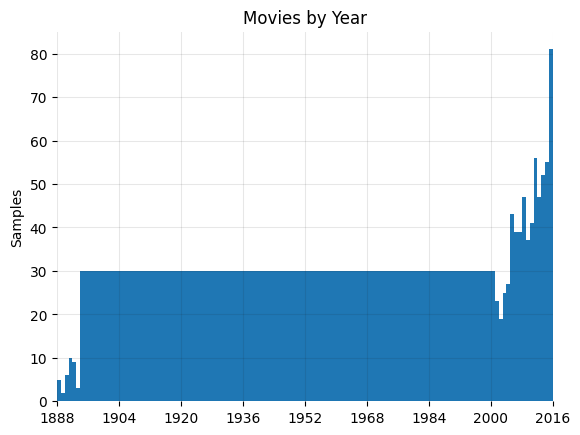

In [42]:
plt.figure(2)
plt.hist(df_years_new, bins=128)
plt.gca().set(title='Movies by Year', ylabel='Samples')
plt.xlim(1888, 2016)
plt.xticks(np.arange(1888, 2017, 16))
plt.grid(True)
plt.rcParams['grid.color'] = (0.1, 0.1, 0.1, 0.1)
for pos in ['right', 'top', 'bottom', 'left']:
    plt.gca().spines[pos].set_visible(False)

Now, we can see that the majority of the years are decently represented by 30 movies each. Due to lack of time, there is still room for improvement. Possible improvements are:

* Try to find additional posters for the underrepresented years after 1888 and the early 2000s.
* Undersample all years (somewhere after 2005-2006) that exceed the number of samples threshold `t` which was set at 30, so we achieve a uniform distribution and we minimise any bias.
* Increase the threshold `t` to 40/50/or even greater - this would be proportional to the time requred for data scraping and preprocessing, but would increase the dataset size and allow for even higher performence.
* Look into getting data for years after 2016 and maybe even before 1888 (if anything that far ago exists).

Finally, we can test the same model with the bigger dataset:

In [44]:
all_images_preprocessesed = preprocess_input(all_images)

normalizer2 = tf.keras.layers.Normalization(axis=-1)
normalizer2.adapt(np.array(all_images_preprocessesed))

(X_train, X_test,
 y_train, y_test) = train_test_split(all_images_preprocessesed, all_labels,
                                     train_size = 0.8, random_state = 22229358)

# Freeze the weights of the base model
for layer in base_model.layers:
    layer.trainable = False

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  patience=5,
                                                  restore_best_weights=True,)

regression_model2 = models.Sequential()
regression_model2.add(base_model)
regression_model2.add(layers.Flatten())
regression_model2.add(layers.Dense(320, activation='relu'))
regression_model2.add(layers.Dense(160, activation='relu'))
regression_model2.add(layers.Dense(1))

regression_model2.compile(loss='mean_absolute_error',
                         optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))

history2 = regression_model2.fit(
    all_images_preprocessesed,
    all_labels,
    batch_size = 1,
    epochs = 50,
    validation_split = 0.2,
    callbacks=[early_stopping])

result2 = regression_model2.evaluate(X_test, y_test)
result2

Epoch 1/50
2761/2761 [==============================] - 565s 203ms/step - loss: 365.0312 - val_loss: 219.3016
Epoch 2/50
2761/2761 [==============================] - 552s 200ms/step - loss: 243.3567 - val_loss: 260.6722
Epoch 3/50
2761/2761 [==============================] - 550s 199ms/step - loss: 181.1660 - val_loss: 177.0968
Epoch 4/50
2761/2761 [==============================] - 550s 199ms/step - loss: 160.3141 - val_loss: 265.5638
Epoch 5/50
2761/2761 [==============================] - 555s 201ms/step - loss: 142.6208 - val_loss: 205.1131
Epoch 6/50
2761/2761 [==============================] - 551s 200ms/step - loss: 124.7492 - val_loss: 194.6374
Epoch 7/50
2761/2761 [==============================] - 550s 199ms/step - loss: 110.2486 - val_loss: 172.8452
Epoch 8/50
2761/2761 [==============================] - 550s 199ms/step - loss: 102.4027 - val_loss: 158.5043
Epoch 9/50
2761/2761 [==============================] - 551s 200ms/step - loss: 95.8291 - val_loss: 167.2580
Epoch 10/50

89.38233184814453

We have now achieved a mean absolute loss of about 89 on the test dataset and that is only in 20 epochs. This is far better than with the smaller dataset where the loss with the same configuration was about 278 on the test dataset.

Let's see if there is any difference in the behaviour of the loss curves:

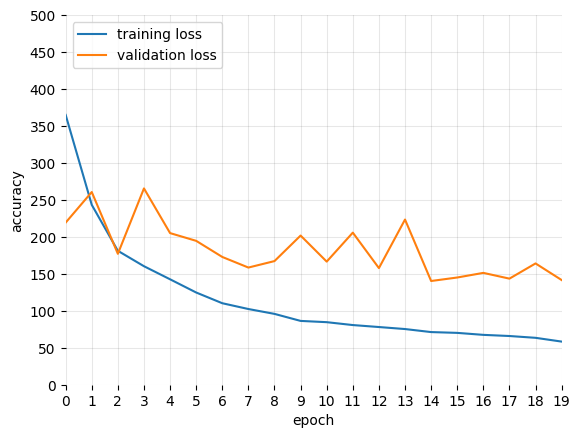

In [80]:
plt.figure(3)
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training loss', 'validation loss'], loc='upper left')
plt.xlim(0, 19)
plt.xticks(np.arange(0, 20, 1))
plt.ylim(0, 500)
plt.yticks(np.arange(0, 501, 50))
plt.grid(True)
plt.rcParams['grid.color'] = (0.1, 0.1, 0.1, 0.1)
for pos in ['right', 'top', 'bottom', 'left']:
    plt.gca().spines[pos].set_visible(False)
plt.show()

This time overfitting is a lot better than the previous time. The model is still a little overfit but the validation curve doesn't diverge as much from the training curve and actually it looks like there is still possibility for improvement even after the 20th epoch.

### Summary of results

![movies_distribution_1](./plots/movies_distribution_1.png)

![movies_distribution_2](./plots/movies_distribution_2.png)

![loss_curve_1](./plots/loss_curve_1.png)

![loss_curve_2](./plots/loss_curve_2.png)

The results seem promising and it deffinitely seems possible to correlate the movie poster with the year of release. My approach involved only improving the data and the model. The data could be imporoved way more and the actual model could still be imporoved which might eventually lead to an amazing precission of the predictions.